In [83]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
%autoreload 2

from autogluon.tabular import TabularDataset
from lib.autogluon import MultilabelPredictor
import pandas as pd
from autogluon.core.metrics import make_scorer
import json


from lib.geo_utils import median_distance, haversine_lat_distance, haversine_lon_distance, plot_switzerland

config_name = 'utm_lr2e-5'

## Training

Let's now apply our multi-label predictor to predict multiple columns in a data table. We first train models to predict each of the labels.

In [85]:
train_data = TabularDataset(pd.read_table('../vardial-shared-tasks/SMG2020/ch/train.txt'))
dev_data = TabularDataset(pd.read_table('../vardial-shared-tasks/SMG2020/ch/dev.txt'))
test_gold_data = TabularDataset(pd.read_table('../vardial-shared-tasks/SMG2020/ch/test_gold.txt'))

train_data.columns = ['lat', 'lon', 'text']
dev_data.columns = ['lat', 'lon', 'text']
test_gold_data.columns = ['lat', 'lon', 'text']

# subsample_size = 500  # subsample subset of data for faster demo, try setting this to much larger values
# train_data = train_data.sample(n=subsample_size, random_state=0)
train_data.head()

,lat,lon,text
0,46.86,8.21,Mini Fründin hed Lust uf Doktorspieli gha... ....
1,47.39,8.18,Slayer isch besser. Det han ich gescht mini Dr...
2,47.37,8.78,gaht au innere stund? bin grad am speck brate ...
3,47.39,8.04,sie: thy er: ? sie: thy= thank you er: player ...
4,47.37,8.54,wennd mal amene fritig 1 h länger muesch schaf...


In [86]:
with open('./configs.json', 'r') as f:
    configs = json.load(f)

config = configs[config_name]

In [87]:
import numpy as np

def mae_haversine_lat_distance_func(y_true, y_pred): 
    return np.median(haversine_lat_distance(y_true, y_pred))

def mae_haversine_lon_distance_func(y_true, y_pred): 
    return np.median(haversine_lon_distance(y_true, y_pred))

lat_scorer = make_scorer(
    name='mae_haversine_lat',
    score_func=mae_haversine_lat_distance_func,
    optimum=0,
    greater_is_better=False
)

lon_scorer = make_scorer(
    name='mae_haversine_lon',
    score_func=mae_haversine_lon_distance_func,
    optimum=0,
    greater_is_better=False
) 

In [88]:
labels = ['lat', 'lon']  # which columns to predict based on the others
problem_types = ['regression', 'regression']  # type of each prediction problem (optional)
# eval_metrics = [lat_scorer, lon_scorer]  # metrics used to evaluate predictions for each label (optional)
eval_metrics = ['mean_absolute_error', 'mean_absolute_error']  # metrics used to evaluate predictions for each label (optional)
save_path = '../data/ch/autogluon_results/'  # specifies folder to store trained models (optional)

time_limit = 20  # how many seconds to train the TabularPredictor for each label, set much larger in your applications!

In [89]:
import uuid

dump_model_path = f"./tmp/{uuid.uuid4().hex}-automm_sst"

hyperparameters={
    "model.hf_text.checkpoint_name": dump_model_path
}

In [90]:
multi_predictor = MultilabelPredictor(labels=labels, problem_types=problem_types, 
                                      eval_metrics=eval_metrics, path=save_path, consider_labels_correlation=True)
multi_predictor.fit(train_data, time_limit=time_limit, hyperparameters=hyperparameters)

Beginning AutoGluon training ... Time limit = 20s
AutoGluon will save models to "../data/ch/autogluon_results/Predictor_lat"
AutoGluon Version:  0.8.3b20231115
Python Version:     3.11.6
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Disk Space Avail:   806.49 GB / 1023.54 GB (78.8%)
Train Data Rows:    22599
Train Data Columns: 1
Label Column: lat
Preprocessing data ...
c:\Users\koholm\dev\TDT13\venv\Lib\site-packages\autogluon\tabular\learner\default_learner.py:215: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    56362.28 MB
	Train Data (Original)  Memory Usage: 25.81 MB (0.0% of available memory)
	Inferring data type of each feature b

Fitting TabularPredictor for label: lat ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['text']
			CountVectorizer fit with vocabulary size = 5495
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('object', ['text']) : 1 | ['text']
	Types of features in processed data (raw dtype, special dtypes):
		('int', ['binned', 'text_special']) :   35 | ['text.char_count', 'text.word_count', 'text.capital_ratio', 'text.lower_ratio', 'text.digit_ratio', ...]
		('int', ['text_ngram'])             : 5386 | ['__nlp__.00', '__nlp__.000', '__nlp__.10', '__nlp__.10 min', '__nlp__.100', ...]
	12.8s = Fit runtime
	1 features in original data used to generate 5421 features in processed data.
	Train Data (Processed) Memory Usage: 244.23 MB (0.4% of available memory)
Data preprocessing an

ValueError: Unknown custom model preset: ./tmp/31a1645f1a6e48ff8908880f037928ba-automm_sst

## Inference and Evaluation

After training, you can easily use the `MultilabelPredictor` to predict all labels in new data:

In [ ]:
multi_predictor = MultilabelPredictor.load(save_path)  # unnecessary, just demonstrates how to load previously-trained multilabel predictor from file

predictions = multi_predictor.predict(test_gold_data)
print("Predictions:  \n", predictions)

c:\Users\koholm\dev\TDT13\venv\Lib\site-packages\autogluon\features\generators\fillna.py:58: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  X.fillna(self._fillna_feature_map, inplace=True, downcast=False)


Predicting with TabularPredictor for label: lat ...
Predicting with TabularPredictor for label: lon ...


c:\Users\koholm\dev\TDT13\venv\Lib\site-packages\autogluon\features\generators\fillna.py:58: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  X.fillna(self._fillna_feature_map, inplace=True, downcast=False)


Predictions:  
             lat       lon
0     47.273018  8.048025
1     47.434998  8.098163
2     47.282394  8.700470
3     47.262672  8.547313
4     47.364777  8.013473
...         ...       ...
3091  47.269695  8.522215
3092  47.422432  8.314219
3093  47.095284  7.950830
3094  47.215378  8.123056
3095  47.314545  8.492593

[3096 rows x 2 columns]


We can also easily evaluate the performance of our predictions if our new data contain the ground truth labels:

In [ ]:
evaluations = multi_predictor.evaluate(test_gold_data)
print(evaluations)
print("Evaluated using metrics:", multi_predictor.eval_metrics)

Evaluating TabularPredictor for label: lat ...


c:\Users\koholm\dev\TDT13\venv\Lib\site-packages\autogluon\features\generators\fillna.py:58: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  X.fillna(self._fillna_feature_map, inplace=True, downcast=False)
Evaluation: mean_absolute_error on test data: -0.19691097624234127
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "mean_absolute_error": -0.19691097624234127,
    "root_mean_squared_error": -0.2485169276160224,
    "mean_squared_error": -0.06176066331170731,
    "r2": -0.0015975577747209257,
    "pearsonr": 0.22014068048344343,
    "median_absolute_error": -0.1679328918457017
}
c:\Users\koholm\dev\TDT13\venv\Lib\site-packages\autogluon\features\generators\fillna.py:58: FutureWarning: The 'downcast' key

Evaluating TabularPredictor for label: lon ...


c:\Users\koholm\dev\TDT13\venv\Lib\site-packages\autogluon\features\generators\fillna.py:58: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  X.fillna(self._fillna_feature_map, inplace=True, downcast=False)
Evaluation: mean_absolute_error on test data: -0.5008118772629928
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "mean_absolute_error": -0.5008118772629928,
    "root_mean_squared_error": -0.6188155168692656,
    "mean_squared_error": -0.3829326439181764,
    "r2": 0.00795416922461789,
    "pearsonr": 0.220476984585336,
    "median_absolute_error": -0.4339935111999518
}
c:\Users\koholm\dev\TDT13\venv\Lib\site-packages\autogluon\features\generators\fillna.py:58: FutureWarning: The 'downcast' keyword in 

{'lat': {'mean_absolute_error': -0.19691097624234127, 'root_mean_squared_error': -0.2485169276160224, 'mean_squared_error': -0.06176066331170731, 'r2': -0.0015975577747209257, 'pearsonr': 0.22014068048344343, 'median_absolute_error': -0.1679328918457017}, 'lon': {'mean_absolute_error': -0.5008118772629928, 'root_mean_squared_error': -0.6188155168692656, 'mean_squared_error': -0.3829326439181764, 'r2': 0.00795416922461789, 'pearsonr': 0.220476984585336, 'median_absolute_error': -0.4339935111999518}}
Evaluated using metrics: {'lat': 'mean_absolute_error', 'lon': 'mean_absolute_error'}


In [ ]:
median_distance(predictions, test_gold_data[['lat', 'lon']])

42.68285636904994

In [94]:
predictions, test_gold_data[['lat', 'lon']]

(            lat       lon
 0     47.273018  8.048025
 1     47.434998  8.098163
 2     47.282394  8.700470
 3     47.262672  8.547313
 4     47.364777  8.013473
 ...         ...       ...
 3091  47.269695  8.522215
 3092  47.422432  8.314219
 3093  47.095284  7.950830
 3094  47.215378  8.123056
 3095  47.314545  8.492593
 
 [3096 rows x 2 columns],
         lat   lon
 0     47.36  8.00
 1     47.41  8.40
 2     46.95  9.57
 3     47.70  8.53
 4     47.26  8.60
 ...     ...   ...
 3091  47.48  8.45
 3092  47.19  8.74
 3093  47.41  8.46
 3094  47.50  8.75
 3095  47.48  7.74
 
 [3096 rows x 2 columns])

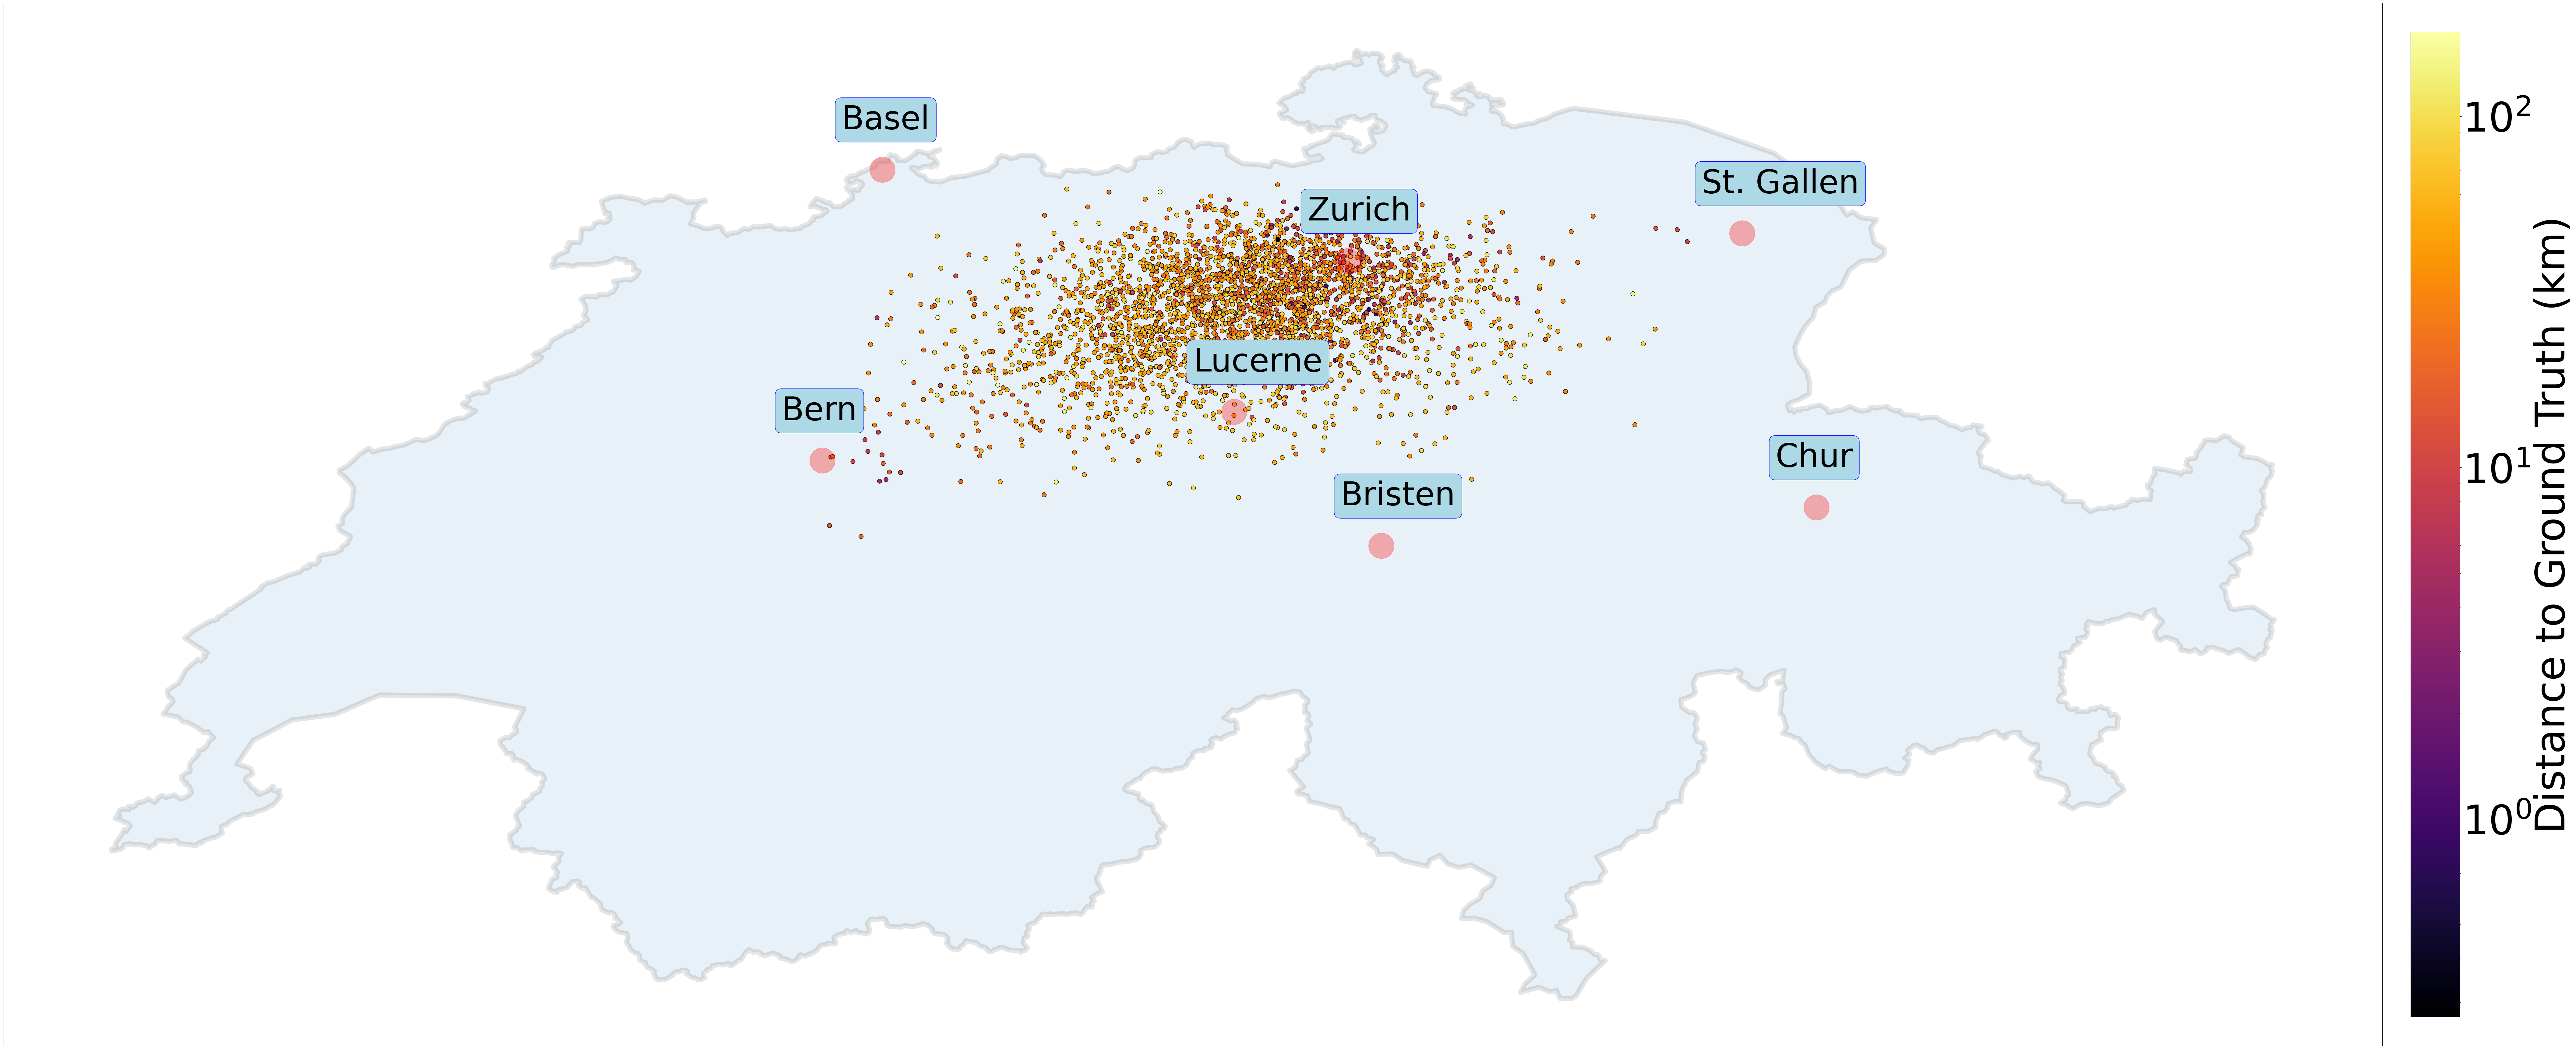

In [98]:
plot_switzerland(predictions.to_numpy(), test_gold_data[['lat', 'lon']], '../data/')

## Accessing the TabularPredictor for One Label

We can also directly work with the `TabularPredictor` for any one of the labels as follows. However we recommend you set `consider_labels_correlation=False` before training if you later plan to use an individual `TabularPredictor` to predict just one label rather than all of the labels predicted by the `MultilabelPredictor`.

In [ ]:
predictor_class = multi_predictor.get_predictor('lon')
predictor_class.leaderboard(silent=True)

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.495387,mean_absolute_error,3.961949,3.425912,0.000997,0.039826,2,True,3
1,KNeighborsDist,-0.504118,mean_absolute_error,1.529260,1.511446,1.529260,1.511446,1,True,2
2,KNeighborsUnif,-0.505085,mean_absolute_error,2.431693,1.874640,2.431693,1.874640,1,True,1


## Tips

In order to obtain the best predictions, you should generally add the following arguments to `MultilabelPredictor.fit()`:

1) Specify `eval_metrics` to the metrics you will use to evaluate predictions for each label

2) Specify `presets='best_quality'` to tell AutoGluon you care about predictive performance more than latency/memory usage, which will utilize stack ensembling when predicting each label.


If you find that too much memory/disk is being used, try calling `MultilabelPredictor.fit()` with additional arguments discussed under ["If you encounter memory issues" in the In Depth Tutorial](../tabular-indepth.ipynb) or ["If you encounter disk space issues"](../tabular-indepth.ipynb).

If you find inference too slow, you can try the strategies discussed under ["Accelerating Inference" in the In Depth Tutorial](../tabular-indepth.ipynb).
In particular, simply try specifying the following preset in `MultilabelPredictor.fit()`: `presets = ['good_quality', 'optimize_for_deployment']`